# **4. ML - Classification**

In [ ]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Métricas de evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Guardado del modelo
import joblib

In [4]:
# Cargar el archivo CSV
df = pd.read_csv('../data/processed/campana_marketing.csv', parse_dates=['Dt_Customer'])

# Convertir la columna 'Income' de float64 a int64
df['Income'] = df['Income'].astype('int64')

## Nuestra variable objetivo será `AcceptedCmp`: 0 no se ha aceptado ninguna campaña y 1 se ha aceptado al menos 1 de las 5 campañas

In [5]:
# 1. Correlación con el Target
correlation_matrix = df.corr(numeric_only=True)
correlation_with_target = correlation_matrix['AcceptedCmp'].sort_values(ascending=False)
correlation_with_target

AcceptedCmp            1.000000
AcceptedCmp4           0.553782
AcceptedCmp3           0.551957
AcceptedCmp5           0.548292
AcceptedCmp1           0.510624
MntWines               0.465034
Spent                  0.412466
Response               0.367401
Income                 0.315024
NumCatalogPurchases    0.313291
MntMeatProducts        0.274626
AcceptedCmp2           0.229464
NumWebPurchases        0.213228
MntGoldProds           0.190782
NumStorePurchases      0.186765
MntFishProducts        0.160046
MntSweetProducts       0.159584
MntFruits              0.126553
Education              0.047823
Age                    0.030778
Marital_Status        -0.000198
Days                  -0.013751
Seniority             -0.013751
Recency               -0.017745
Complain              -0.027016
Year_Birth            -0.030778
ID                    -0.041206
NumDealsPurchases     -0.086570
Teenhome              -0.099415
NumWebVisitsMonth     -0.125986
Kidhome               -0.203024
Child_Ho

## Selección de variables X e Y

1. Determinamos que las variables con una correlación entre 0.2 y -0.2 quedarán excluidas de nuestro entrenamiento, ya que se encuentran entorno al 0 y parecen que no afectan a la variable objetivo y así aligeramos el proceso de entrenamiento.
2. Usando una **list comprehension** eliminamos las características `AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5 y Response`, ya que son o subproducto de AcceptedCmp o bien una característica condicionada.

In [6]:
# Filtrar correlaciones fuera del rango [-0.2, 0.2]
filtered_correlations = correlation_with_target[
    correlation_with_target.abs() > 0.2
].sort_values(ascending=False)

# Lista final de features, excluyendo las variables derivadas de 'AcceptedCmp'
excluded_features = ['AcceptedCmp', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
features = [f for f in filtered_correlations.index if f not in excluded_features]

print("Características seleccionadas:", features)

Características seleccionadas: ['MntWines', 'Spent', 'Income', 'NumCatalogPurchases', 'MntMeatProducts', 'NumWebPurchases', 'Kidhome', 'Child_Home']


Definimos las variables

In [7]:
X = df[features]
y = df['AcceptedCmp']

## División de datos
Cogeremos el 20% para test y el 80% para training

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tratamiento del Desbalance de Clases
Como vimos en [**EDA**](04_explore_data.ipynb), al final del análisis no gráfico, `AcceptedCmp` tiene la clase está desbalanceada.
En este escenario, la clase minoritaria (en nuestro caso, la clase 1) está significativamente menos representada que la clase mayoritaria (la clase 0). Esto puede generar varios problemas al entrenar un modelo de clasificación.

### Rebalancear clases
Optamos por hacer un Submuestreo (**Undersampling**), reduciendo el número de ejemplos de la clase mayoritaria.

Dada la significativa disparidad en la representación de las clases en nuestro conjunto de datos, con una marcada predominancia de la clase mayoritaria (clase 0), se ha optado por aplicar la técnica de submuestreo (undersampling). El objetivo principal de esta estrategia es reducir el número de instancias de la clase mayoritaria para mitigar el sesgo del modelo hacia esta clase y mejorar su capacidad para aprender y predecir la clase minoritaria (clase 1) de manera más efectiva.

In [9]:
# Aplicar undersampling para balancear las clases
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

## Estandarización con `StandardScaler`
1. Se estandarizan los datos para el entrenamiento de modelos de **Regresión Logística** y **SVM** porque son sensibles a la escala de las características, lo que puede afectar su convergencia y rendimiento. 
2. Para **KNN** y **Random Forest**, la estandarización no es estrictamente necesaria debido a su funcionamiento basado en distancias relativas o divisiones de características individuales, y para **Redes Neuronales**, la decisión se toma considerando el contexto específico del experimento.

In [10]:
# Aplicamos StandardScaler solo a los datos originales (sin rebalanceo)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Selección de modelos
Para el **Desbalance de Clases**, ajustamos pesos en el modelo (más fácil y eficiente) con `class_weight='balanced`. 

Como los modelos **KNN** y **Neural Network** no son compatibles para que se ajusten, aquí sí que aplicaremos el undersampling `X_resampled, y_resample` que se ha hecho previamente.

Los datos ya estandarizados `X_train_scaled`se usarán solo para entrenar en los modelos **Logistic Regression** y **SVM**.

In [11]:
# Modelos con ajuste de pesos para modelos compatibles
models = {
    'Logistic Regression': (LogisticRegression(max_iter=2000, class_weight='balanced'), X_train_scaled, y_train),
    'KNN': (KNeighborsClassifier(), X_resampled, y_resampled),
    'Random Forest': (RandomForestClassifier(class_weight='balanced'), X_train, y_train),
    'SVM': (SVC(probability=True, class_weight='balanced'), X_train_scaled, y_train),
    'Neural Network': (MLPClassifier(), X_resampled, y_resampled)
}

## Hiperparámetros para la Búsqueda Exhaustiva con GridSearchCV

In [12]:
# Hiperparámetros para GridSearchCV
param_grid = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 'log2'], 'max_depth': [3, 5, 10]},
    'SVM': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]},
    'Neural Network': {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01, 0.05],
        'learning_rate': ['constant','adaptive']
    }
}

## Entrenamiento

In [13]:
results = {}
best_models = {}

for model_name, (model, X_data, y_data) in models.items():
    print(f"\nEntrenando {model_name}...")

    grid_search = GridSearchCV(model, param_grid[model_name], scoring='roc_auc', n_jobs=-1, cv=5)
    grid_search.fit(X_data, y_data)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Usar X_test_scaled solo en modelos que lo requieren
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test

    y_pred = best_model.predict(X_test_final)

    # Verificar si el modelo tiene 'predict_proba'
    if hasattr(best_model, "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]
    else:
        y_pred_proba = np.zeros_like(y_pred)  # En caso de que el modelo no tenga predict_proba

    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
        'Best Params': best_params
    }
    best_models[model_name] = best_model

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results).T
results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']] = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']].astype(float)


Entrenando Logistic Regression...



Entrenando KNN...

Entrenando Random Forest...

Entrenando SVM...

Entrenando Neural Network...


## Resultados

In [14]:
print("\n🔹 Resultados de los modelos:")
print(results_df)

# Determinar el mejor modelo basado en diferentes métricas
best_metrics = {metric: results_df[metric].idxmax() for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']}

print("\n🔹 Mejores modelos por métrica:")
for metric, model in best_metrics.items():
    print(f"Mejor modelo basado en {metric}: {model} - {results_df.at[model, 'Best Params']}")


🔹 Resultados de los modelos:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC  \
Logistic Regression  0.756208   0.476821  0.712871  0.571429  0.789618   
KNN                  0.697517   0.400000  0.653465  0.496241  0.742212   
Random Forest        0.846501   0.698795  0.574257  0.630435  0.846795   
SVM                  0.783296   0.518248  0.702970  0.596639  0.810709   
Neural Network       0.227991   0.227991  1.000000  0.371324  0.500362   

                                                           Best Params  
Logistic Regression                                         {'C': 100}  
KNN                                                {'n_neighbors': 11}  
Random Forest        {'max_depth': 10, 'max_features': 'sqrt', 'n_e...  
SVM                                            {'C': 10, 'gamma': 0.1}  
Neural Network       {'activation': 'tanh', 'alpha': 0.01, 'hidden_...  

🔹 Mejores modelos por métrica:
Mejor modelo basado en Accuracy: Random Forest - {'max_

## Evaluación y Análisis de los Resultados

### **Interpretación Detallada**

### **Random Forest: El Modelo con Mejor Rendimiento General**
* Obtiene la **mayor precisión global (Accuracy: 0.847)** y la **mejor capacidad para identificar correctamente la clase positiva (Precision: 0.699)**.
* También demuestra una **buena capacidad para distinguir entre clases positiva y negativa (ROC AUC: 0.847)**.
* Estos resultados sugieren que **Random Forest es el modelo más robusto** en términos de rendimiento general.

### **Logistic Regression y SVM: Rendimiento Moderado con Enfoque en Recall**
* Ambos modelos presentan un **Recall notable** (Logistic Regression: 0.713, SVM: 0.703), indicando su capacidad para identificar una proporción significativa de la clase positiva.
* Sin embargo, su **Precision es relativamente baja** (Logistic Regression: 0.477, SVM: 0.518), lo que implica una cantidad considerable de falsos positivos.
* **SVM muestra un F1 Score ligeramente superior (0.597 vs. 0.571)** a la Regresión Logística, lo que sugiere un mejor equilibrio entre precisión y recall dentro de este grupo.

### **KNN: Rendimiento Subóptimo**
* Muestra una **precisión baja (0.400)** y un **ROC AUC modesto (0.742)**, lo que sugiere dificultades para generalizar a nuevos datos y una tendencia a clasificar incorrectamente la clase negativa como positiva.
* Este rendimiento indica que KNN no es el modelo más adecuado para este problema.

### **Neural Network: Alto Recall a Costa de Baja Precisión**
* Obtiene el **mayor Recall (1.000)**, lo que significa que identifica correctamente todas las instancias de la clase positiva en el conjunto de prueba.
* No obstante, su **Precision es extremadamente baja (0.228)**, lo que resulta en un número muy elevado de falsos positivos.
* El **ROC AUC (0.500)** es apenas mejor que una predicción aleatoria, lo que indica que el modelo no está aprendiendo a discriminar entre las clases de manera efectiva.

---

## **Conclusiones y Próximos Pasos**

* **Random Forest se destaca como el modelo más prometedor** debido a su rendimiento superior en **Accuracy, Precision y ROC AUC**.
* **Logistic Regression y SVM podrían ser considerados** si el objetivo principal es **maximizar la detección de la clase positiva (alto Recall)**, aunque a costa de una mayor cantidad de falsos positivos. En este caso, **SVM muestra un ligero mejor equilibrio**.
* **La Red Neuronal, a pesar de su Recall perfecto, presenta un problema significativo de falsos positivos**, lo que la hace poco práctica en su estado actual. Se requeriría una **revisión exhaustiva de su arquitectura, hiperparámetros y el preprocesamiento de los datos** si se quisiera explorar su potencial. Sin embargo, dado su costo computacional, no se recomienda seguir esta vía por el momento.
* **El bajo rendimiento constante de KNN** sugiere que este algoritmo no es apropiado para la estructura de este conjunto de datos y la relación entre las características y la variable objetivo.

## Visualización de los Resultados

### Matriz de Confusión

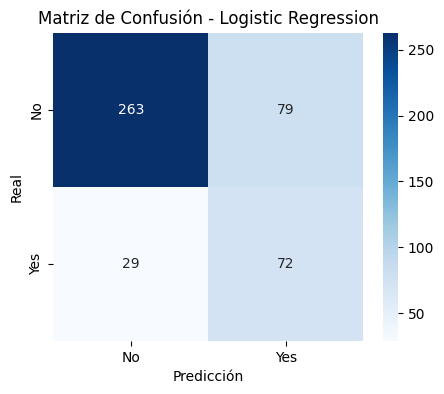

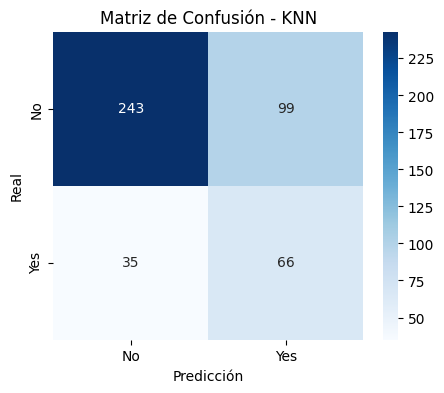

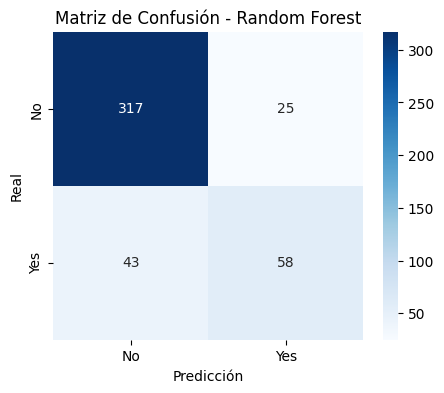

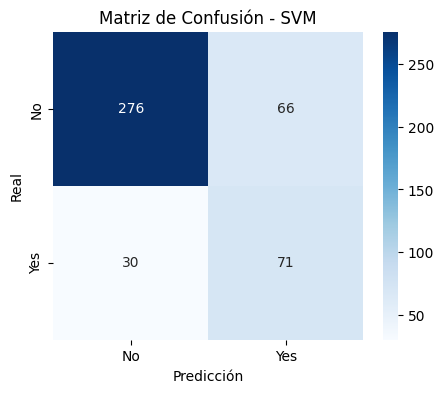

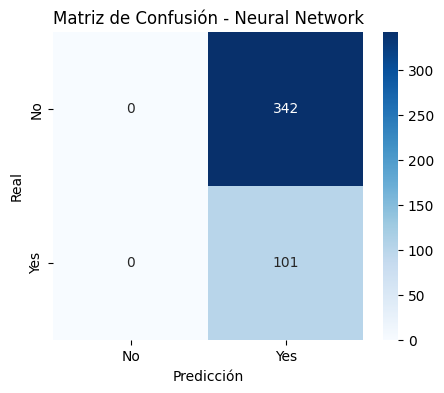

In [15]:
def plot_confusion_matrix(model_name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

# Visualizar para los mejores modelos
for model_name, best_model in best_models.items():
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test
    y_pred = best_model.predict(X_test_final)
    plot_confusion_matrix(model_name, y_test, y_pred)

### Distribución de Probabilidades Predichas vs. Valores Reales

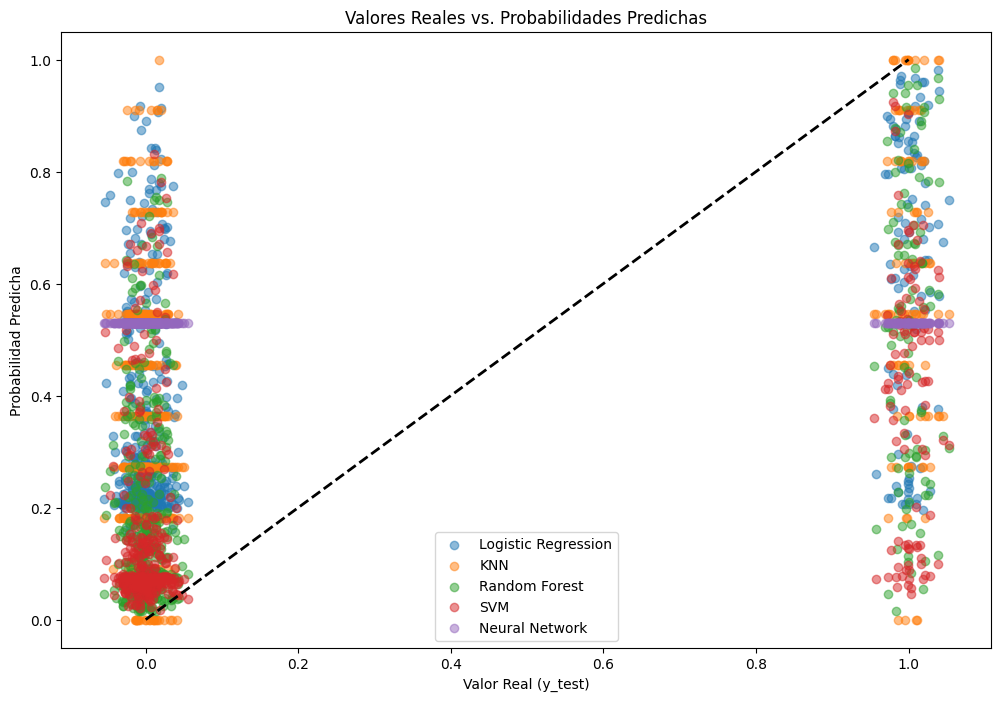

In [16]:
plt.figure(figsize=(12, 8))

jitter = np.random.normal(0, 0.02, size=len(y_test))  # Ruido leve en X para mejor visualización

for model_name, best_model in best_models.items():
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test

    if hasattr(best_model, "predict_proba"):  # Si el modelo tiene predict_proba
        y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]  # Probabilidad de la clase positiva
    else:
        y_pred_proba = best_model.predict(X_test_final)  # Predicción directa

    # Agregar dispersión de puntos
    plt.scatter(y_test + jitter, y_pred_proba, alpha=0.5, label=model_name)

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('Valor Real (y_test)')
plt.ylabel('Probabilidad Predicha')
plt.title('Valores Reales vs. Probabilidades Predichas')
plt.legend()
plt.show()

### Curva ROC

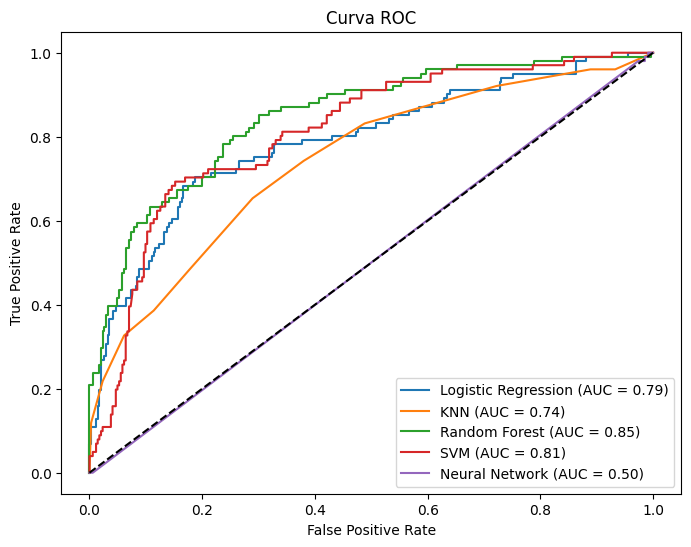

In [17]:
plt.figure(figsize=(8, 6))

for model_name, best_model in best_models.items():
    X_test_final = X_test_scaled if model_name in ['Logistic Regression', 'SVM'] else X_test

    if hasattr(best_model, "predict_proba"):  # Verificar si tiene predict_proba
        y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]
    else:
        continue  # Si el modelo no tiene predict_proba, lo ignoramos

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (modelo aleatorio)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## Considerar un threshold (umbral) en el modelo Random Forest
Por defecto, los modelos de clasificación usan un umbral de 0.5 para decidir entre clases, pero ajustar este threshold puede mejorar el balance entre Precision y Recall, especialmente en datos desbalanceados.

En lugar de simplemente guardar `RandomForestClassifier.pkl` con el threshold por defecto, podemos:

1. Evaluar el impacto de diferentes umbrales en Precision-Recall y ROC Curve.

2. Seleccionar el threshold óptimo según la métrica más relevante (F1 Score, Recall, etc.).

3. Modificar el modelo para usar este threshold en la predicción final antes de su guardado.

### Visualizar cómo varían las métricas según el threshold 

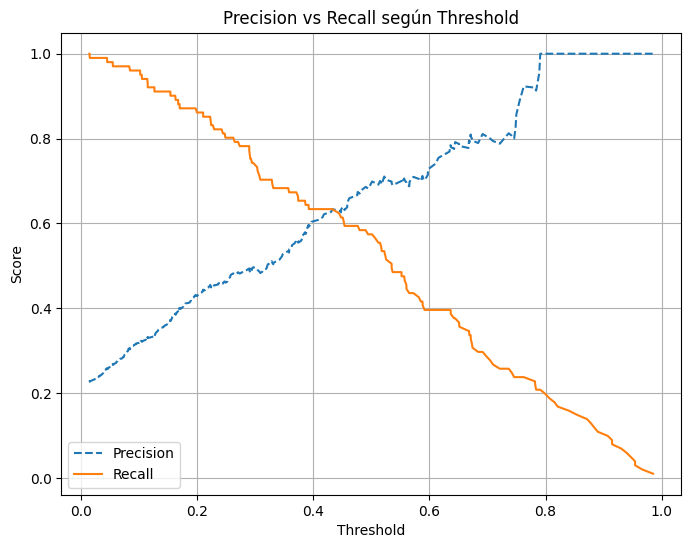

In [18]:
# Obtener probabilidades del mejor modelo (Random Forest)
y_proba = best_models['Random Forest'].predict_proba(X_test)[:, 1]

# Calcular Precision-Recall para diferentes thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Graficar Precision-Recall según threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle="--")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall según Threshold")
plt.legend()
plt.grid()
plt.show()

El gráfico muestra cómo varían **Precision** y **Recall** según el umbral de clasificación.

A medida que el `threshold' aumenta, la **Precision** sube porque el modelo hace predicciones más conservadoras (menos falsos positivos).

Sin embargo, el **Recall** baja, lo que significa que detectamos menos casos positivos reales.

El punto óptimo es donde **Precision** y **Recall** tienen un buen balance. Generalmente se elige el threshold que maximiza el F1 Score, ya que este es el mejor compromiso entre ambas métricas.

### Optimal `Threshold`

In [19]:
# Calcular F1 Score para cada threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_threshold = thresholds[f1_scores.argmax()]  # Umbral con mayor F1 Score

print(f"Optimal Threshold basado en F1 Score: {optimal_threshold:.2f}")

Optimal Threshold basado en F1 Score: 0.43


## Guardar modelo aplicando `ThresholdThreshol`

In [20]:
# Guardamos el modelo junto con el threshold óptimo
joblib.dump((best_models['Random Forest'], optimal_threshold), '../models/RandomForestClassifier.pkl')

['../models/RandomForestClassifier.pkl']